In [2]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jangedoo/utkface-new

100% 331M/331M [00:13<00:00, 29.9MB/s]
100% 331M/331M [00:13<00:00, 24.9MB/s]


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
import os
! unzip utkface-new

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [5]:
import os
import shutil
import random
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import keras
from os import listdir
from os.path import isdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
import tensorflow as tf
from numpy import savez_compressed
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from keras.layers import Input
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, ReLU, BatchNormalization, Conv2D,  MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
utkface_path = '/content/UTKFace/'  
trial_path = '/content/Trial/'

if not os.path.exists(trial_path):
    os.mkdir(trial_path)

genders = [0, 1]
max_num_files = 25

for age in range(1, 81):
    for gender in genders:
        age_gender_files = [f for f in os.listdir(utkface_path) if f.startswith(f"{age}_{gender}_")]
        num_files = len(age_gender_files)
        if num_files < max_num_files:
            num_to_augment = max_num_files - num_files
            for i in range(num_to_augment):
                # Randomly select an existing image
                source_file = random.choice(age_gender_files)
                source_path = os.path.join(utkface_path, source_file)
                dest_file = f"{age}_{gender}_{num_files+i}.jpg"
                dest_path = os.path.join(trial_path, dest_file)
                
                # Apply image augmentation
                img = Image.open(source_path)
                enhancer = ImageEnhance.Brightness(img)
                img = enhancer.enhance(0.5)
                enhancer = ImageEnhance.Contrast(img)
                img = enhancer.enhance(0.5)
                img.save(dest_path)
                
        elif num_files >= max_num_files:
            num_files = max_num_files
            
        for i in range(num_files):
            source_file = age_gender_files[i]
            source_path = os.path.join(utkface_path, source_file)
            dest_path = os.path.join(trial_path, source_file)
            shutil.copy(source_path, dest_path)


In [7]:
len(os.listdir(trial_path))

4000

In [8]:
# Load the Haar cascade file for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
#face_cascade

files = os.listdir(trial_path)
size = len(files)
size_genders = len(genders)
print("Total samples:",size)

Total samples: 4000


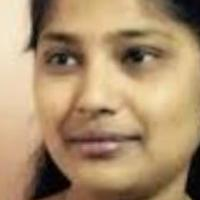

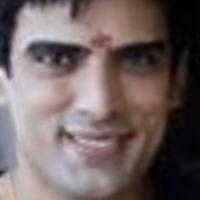

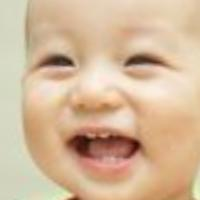

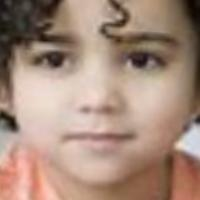

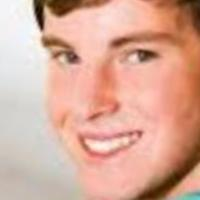

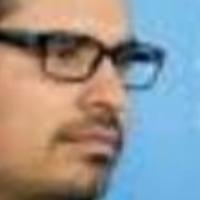

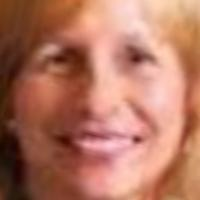

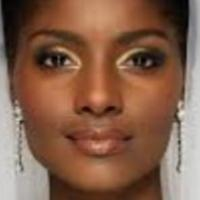

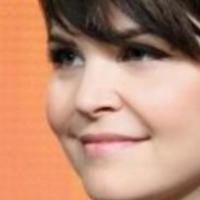

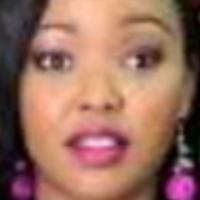

In [9]:
for i in range(10):
    image_path = os.path.join(trial_path, files[i])
    image = cv2.imread(image_path)
    cv2_imshow(image)

In [10]:
img_age_list = []
img_gender_list = []
ages = []
genders = []
filenames = []

for filename in files:
    image_age = cv2.imread(trial_path + filename,1) #,0 for convert the image into gray scale 1 for colour channel
    image_age = cv2.resize(image_age,dsize=(224,224))
    image_gender = cv2.imread(trial_path + filename,1) #,0 for convert the image into gray scale 1 for colour channel
    image_gender = cv2.resize(image_gender,dsize=(224,224))
    img_age_list.append(image_age)
    img_gender_list.append(image_gender)
    ages.append(filename.split('_')[0])
    genders.append(int(filename.split('_')[1]))
    filenames.append(filename)

In [11]:
total_image_age_list = len(img_age_list)
total_image_gender_list = len(img_gender_list)
total_genders = len(genders)
total_ages = len(ages)
idx = 2
print("Total samples for age:",total_image_age_list)
print("Total samples for gender:",total_ages)

Total samples for age: 4000
Total samples for gender: 4000


In [12]:
size_genders

2

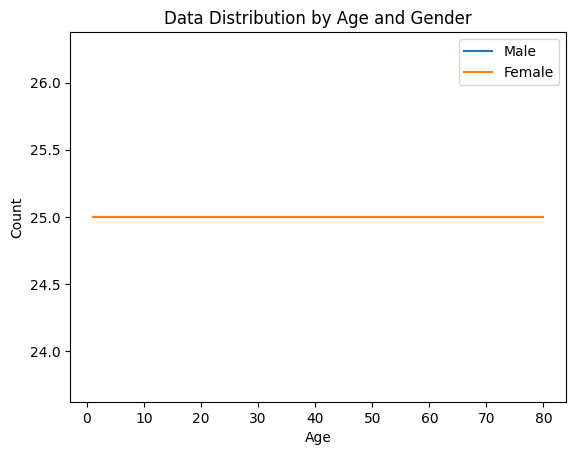

In [13]:
age_gender_counts = {}

for age in range(1, 81):
    for gender in [0, 1]:  # Assuming genders are encoded as 0 and 1
        age_gender_files = [f for f, g in zip(filenames, genders) if int(f.split('_')[0]) == age and g == gender]
        count = len(age_gender_files)
        age_gender_counts[(age, gender)] = count
        
# Separate the counts by gender
male_counts = [age_gender_counts[(age, 1)] for age in range(1, 81)]
female_counts = [age_gender_counts[(age, 0)] for age in range(1, 81)]

# Plotting the data distribution
ages1 = range(1, 81)

plt.plot(ages1, male_counts, label='Male')
plt.plot(ages1, female_counts, label='Female')

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Data Distribution by Age and Gender')
plt.legend()
plt.show()


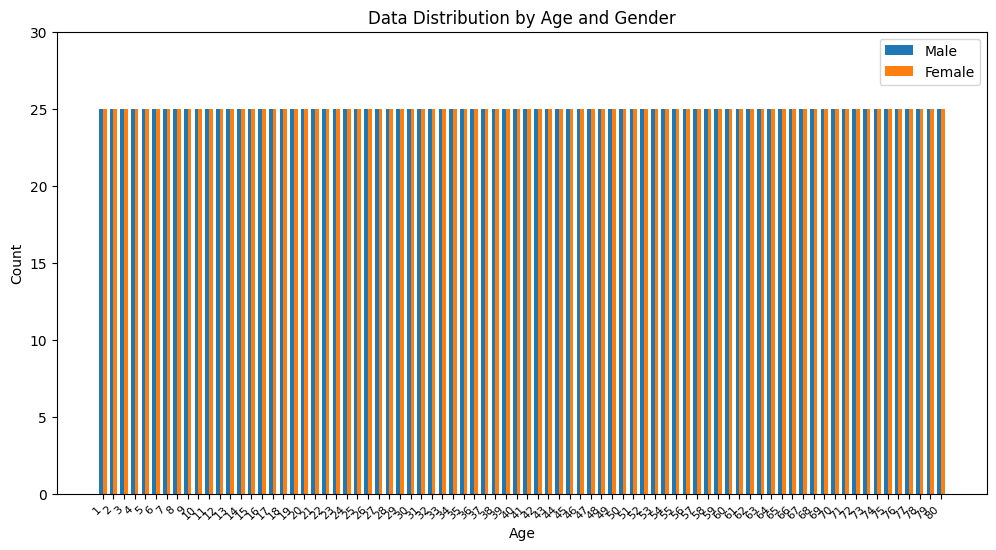

In [14]:
import matplotlib.pyplot as plt
import numpy as np

max_count = max(max(male_counts), max(female_counts))

bar_width = 0.35

bar_positions = np.arange(len(ages1))

plt.figure(figsize=(12, 6))

plt.bar(bar_positions - bar_width/2, male_counts, width=bar_width, label='Male')
plt.bar(bar_positions + bar_width/2, female_counts, width=bar_width, label='Female')

plt.xticks(bar_positions, ages1, rotation=45, ha='right', fontsize=8)
plt.ylim([0, 30])

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Data Distribution by Age and Gender')
plt.legend()

plt.show()


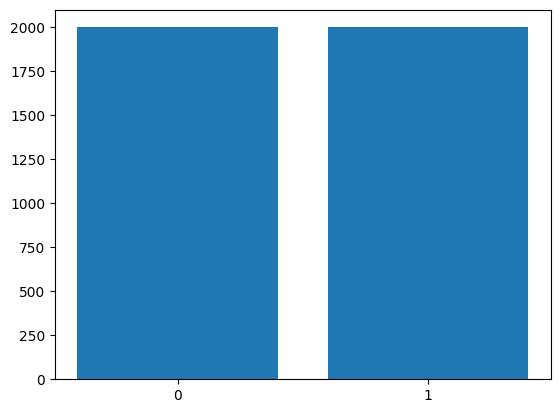

Max value: 1


In [15]:
x_genders = list(set(genders))
y_genders = [genders.count(i) for i in x_genders]

gender_labels = ['0', '1']
plt.bar(gender_labels, y_genders)

plt.show()
print("Max value:",max(genders))


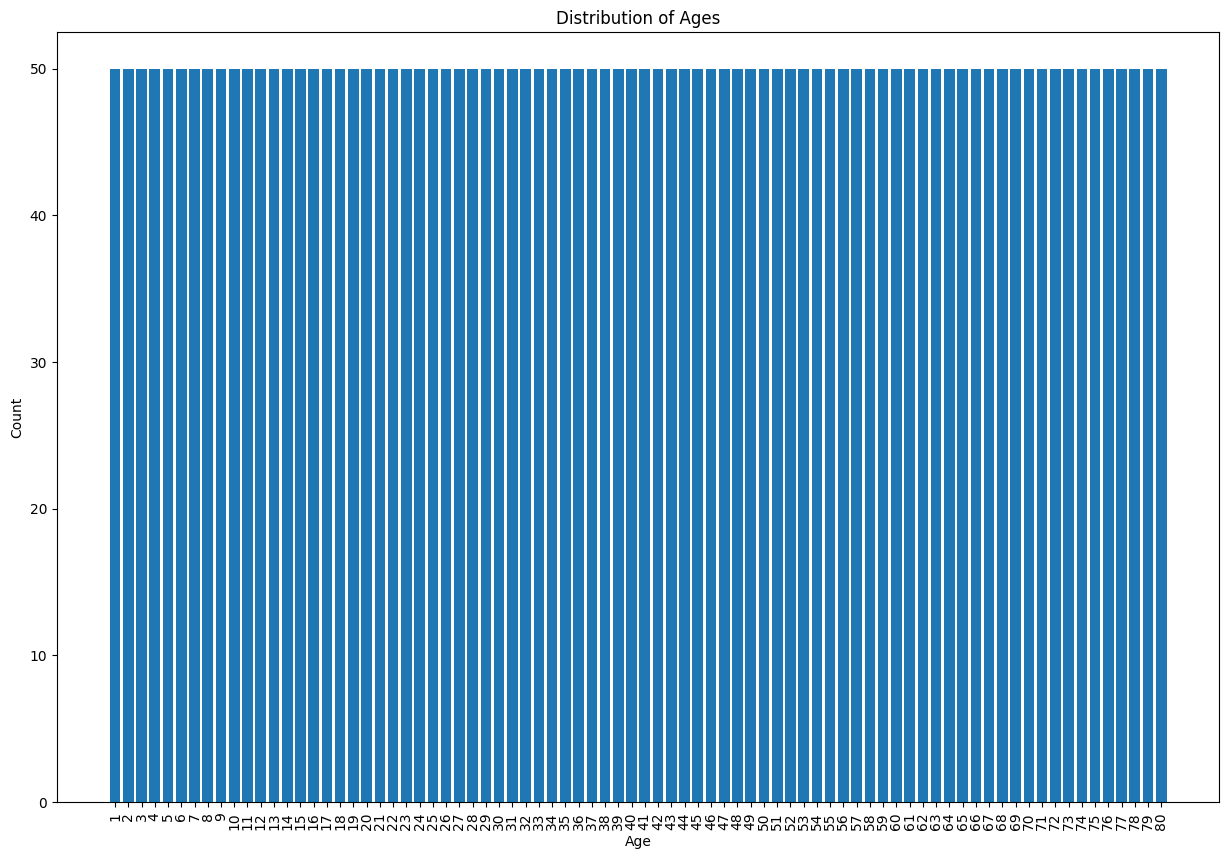

Maximum age: 80


In [16]:
distribution_list = list(set(ages))
distribution_list_int = [int(s) for s in distribution_list]
distribution_list_sorted = sorted(distribution_list_int)


ages_sorted = [str(i).zfill(1) for i in distribution_list_sorted]

x_ages = list(set(ages_sorted))
x_ages = sorted(x_ages)
y_ages = [ages.count(i) for i in x_ages]

plt.figure(figsize=(15, 10)) # set the size of the figure
plt.bar(ages_sorted, y_ages)

plt.xticks(rotation=90) # rotate the x-axis labels by 90 degrees
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')

plt.show()

max_age = max(map(int, x_ages))
print("Maximum age:", max_age)


In [18]:
for_np0 = img_gender_list[0]
labels_age = np.zeros((total_ages,1),dtype='float32')
labels_gender = np.zeros((total_genders,1),dtype='float32')
features_age = np.zeros((total_image_age_list,for_np0.shape[0],for_np0.shape[1],3),dtype = 'float32')
#features_gender = np.zeros((total_genders,sample.shape[0],sample.shape[1],3),dtype = 'float32')
features_gender = np.zeros((total_image_gender_list,for_np0.shape[0],for_np0.shape[1],3),dtype = 'float32')

In [19]:
total_image_age_list

4000

In [20]:
print(labels_age.shape)
print(features_age.shape)
print(labels_gender.shape)
print(features_gender.shape)

(4000, 1)
(4000, 224, 224, 3)
(4000, 1)
(4000, 224, 224, 3)


In [21]:
for i in range(total_image_age_list):
    labels_gender[i, 0] = int(genders[i])
    labels_age[i, 0] = int(ages[i])
    features_age[i] = img_age_list[i]
    features_gender[i] = img_gender_list[i]

In [22]:
normalized_age = features_age / 255 #normalization
normalized_gender = features_gender /255
features_age[0]

array([[[201., 229., 246.],
        [201., 229., 246.],
        [201., 229., 246.],
        ...,
        [ 17.,  10.,  15.],
        [ 16.,  10.,  15.],
        [ 16.,  10.,  15.]],

       [[201., 229., 246.],
        [201., 229., 246.],
        [201., 229., 246.],
        ...,
        [ 17.,  10.,  15.],
        [ 16.,  10.,  15.],
        [ 15.,   9.,  14.]],

       [[201., 229., 246.],
        [201., 229., 246.],
        [201., 229., 246.],
        ...,
        [ 16.,  10.,  13.],
        [ 15.,  10.,  13.],
        [ 15.,  10.,  13.]],

       ...,

       [[107., 145., 187.],
        [107., 145., 187.],
        [109., 146., 186.],
        ...,
        [  4.,   2.,   7.],
        [  6.,   2.,   7.],
        [  9.,   3.,   8.]],

       [[106., 144., 186.],
        [107., 145., 187.],
        [109., 146., 186.],
        ...,
        [  3.,   1.,   6.],
        [  5.,   1.,   6.],
        [  8.,   2.,   7.]],

       [[106., 144., 186.],
        [107., 145., 187.],
        [109., 1

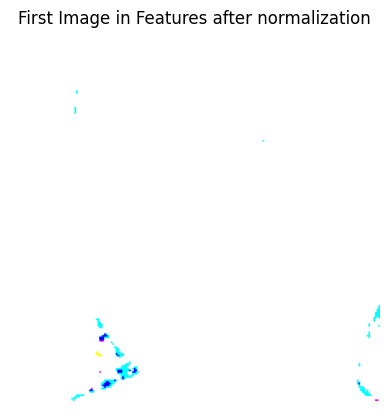

In [23]:
features_first_img_after_normalization = np.clip(features_age[0], 0, 255)
plt.imshow(features_first_img_after_normalization[:, :], vmin=0, vmax=1)
#plt.imshow(features_first_img_after_normalization[:, :, ::-1], vmin=0, vmax=1)
plt.axis('off')

plt.title("First Image in Features after normalization")

plt.show()


In [24]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(normalized_age, labels_age, test_size=0.2,shuffle  = True)

In [25]:

print("--------------------------------------")
print('number of x_train for age: ', len(x_train_age))
print('number of x_test for age: ', len(x_test_age))
print('number of y_train for age: ', len(y_train_age))
print('number of y_test for age:', len(y_test_age))

print("--------------------------------------")
print('x_train type for age:', type(x_train_age))
print('x_test type for age:', type(x_test_age))
print('y_train type for age:', type(y_train_age))
print('y_test type for age:', type(y_test_age))
print("--------------------------------------")

print(y_train_age.shape)

print(y_test_age.shape)


--------------------------------------
number of x_train for age:  3200
number of x_test for age:  800
number of y_train for age:  3200
number of y_test for age: 800
--------------------------------------
x_train type for age: <class 'numpy.ndarray'>
x_test type for age: <class 'numpy.ndarray'>
y_train type for age: <class 'numpy.ndarray'>
y_test type for age: <class 'numpy.ndarray'>
--------------------------------------
(3200, 1)
(800, 1)


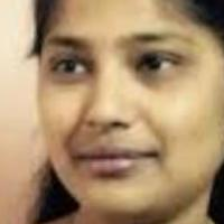

Filename: 27_1_3_20170119194359132.jpg.chip.jpg
Actual age: 27
Gender: 1


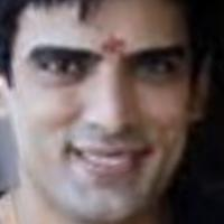

Filename: 25_0_3_20170117151048707.jpg.chip.jpg
Actual age: 25
Gender: 0


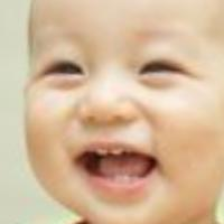

Filename: 1_0_2_20161219161919870.jpg.chip.jpg
Actual age: 1
Gender: 0


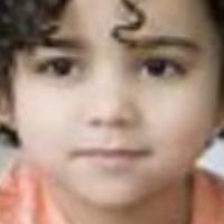

Filename: 2_1_4_20170103205810354.jpg.chip.jpg
Actual age: 2
Gender: 1


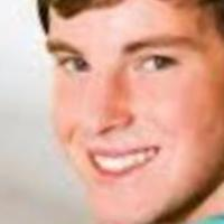

Filename: 20_0_0_20170105183430767.jpg.chip.jpg
Actual age: 20
Gender: 0


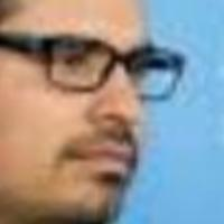

Filename: 26_0_4_20170117200225399.jpg.chip.jpg
Actual age: 26
Gender: 0


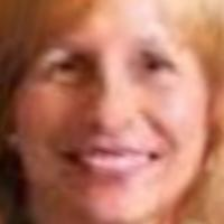

Filename: 40_1_0_20170117091304525.jpg.chip.jpg
Actual age: 40
Gender: 1


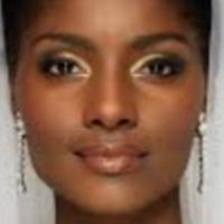

Filename: 20_1_1_20170113005500606.jpg.chip.jpg
Actual age: 20
Gender: 1


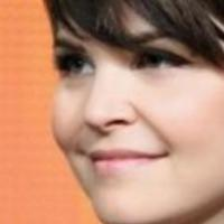

Filename: 26_1_0_20170117175317465.jpg.chip.jpg
Actual age: 26
Gender: 1


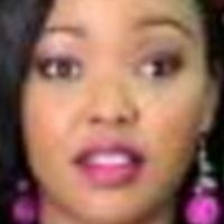

Filename: 26_1_1_20170116153234172.jpg.chip.jpg
Actual age: 26
Gender: 1


In [26]:
for i in range(10):
  filenumber = img_gender_list[i]
  cv2_imshow(filenumber)
  name_of_files = filenames[i]
  print("Filename:", name_of_files)
  print("Actual age:", ages[i])
  print("Gender:", genders[i])

In [27]:
# Model architecture
input_shape = (224, 224, 3)
inputs_age = Input(shape=input_shape)

x_age = Conv2D(32, (3,3), activation='relu', bias_initializer='zeros')(inputs_age)
x_age = MaxPooling2D((2, 2))(x_age)
x_age = Dropout(0.5)(x_age)
x_age = Conv2D(64, (3,3), activation='relu', bias_initializer='zeros')(x_age)
x_age = MaxPooling2D((2, 2))(x_age)
x_age = Dropout(0.5)(x_age)
x_age = Conv2D(128, (3,3), activation='relu', bias_initializer='zeros')(x_age)
x_age = MaxPooling2D((2, 2))(x_age)
x_age = Dropout(0.5)(x_age)

x_age = Flatten()(x_age)
x_age = Dense(64, activation='relu', bias_initializer='zeros')(x_age)
outputs_age = Dense(1, activation='linear', bias_initializer='zeros')(x_age)

neural_network_age = Model(inputs=inputs_age, outputs=outputs_age)
neural_network_age.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [28]:
# Define some callbacks to avoid overfitting
callbacks = [ ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=2) ]

# Train the model
history_age = neural_network_age.fit(x_train_age, y_train_age,
                    batch_size = 20,
                    epochs=45,
                    validation_data=(x_test_age, y_test_age),
                    callbacks=callbacks)


Epoch 1/45
160/160 [==============================] - 22s 60ms/step - loss: 735.4110 - mae: 22.4206 - val_loss: 806.8712 - val_mae: 23.6091 - lr: 0.0010
Epoch 2/45
160/160 [==============================] - 8s 53ms/step - loss: 499.8556 - mae: 19.0384 - val_loss: 512.3865 - val_mae: 19.5041 - lr: 0.0010
Epoch 3/45
160/160 [==============================] - 8s 53ms/step - loss: 382.6653 - mae: 16.1313 - val_loss: 413.8086 - val_mae: 16.9856 - lr: 0.0010
Epoch 4/45
160/160 [==============================] - 8s 53ms/step - loss: 337.7192 - mae: 14.9146 - val_loss: 420.1461 - val_mae: 17.1483 - lr: 0.0010
Epoch 5/45
160/160 [==============================] - 8s 52ms/step - loss: 327.3570 - mae: 14.6935 - val_loss: 425.0591 - val_mae: 17.3193 - lr: 0.0010
Epoch 6/45
160/160 [==============================] - 8s 52ms/step - loss: 309.4221 - mae: 14.2542 - val_loss: 384.4009 - val_mae: 15.9065 - lr: 0.0010
Epoch 7/45
160/160 [==============================] - 8s 52ms/step - loss: 288.2688 - m

In [29]:
age_pred = neural_network_age.predict(x_test_age)


25/25 [==============================] - 1s 15ms/step


In [30]:
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

for i in range(50):
  filenumber = img_gender_list[i]
  cv2_imshow(filenumber)
  name_of_files = filenames[i]
  print("Filename:", name_of_files)
  print("Real age    | Predict age")
  print(ages[i], "         |" , int(age_pred[i]))

Output hidden; open in https://colab.research.google.com to view.

In [31]:
neural_network_age.save('neural_network_age.h5')


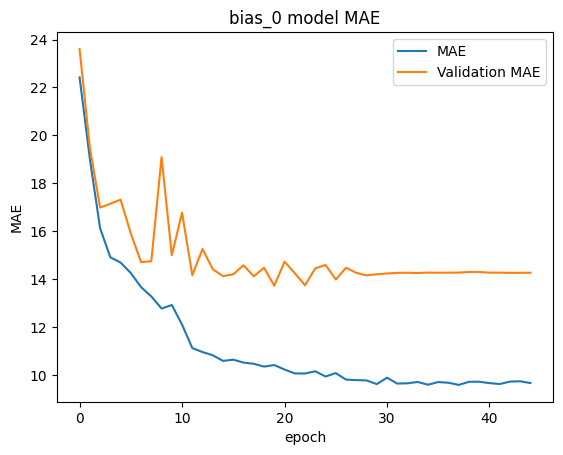

In [39]:
plt.plot(history_age.history['mae'])
plt.plot(history_age.history['val_mae'])
plt.title('bias_0 model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(["MAE","Validation MAE"])
plt.show()

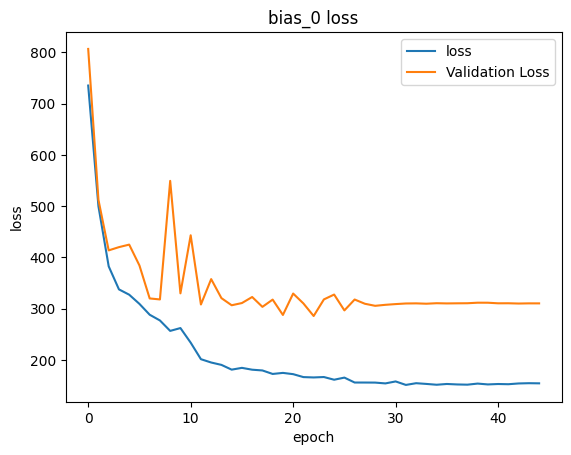

In [40]:
plt.plot(history_age.history['loss'])
plt.plot(history_age.history['val_loss'])
plt.title('bias_0 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["loss","Validation Loss"])
plt.show()

In [34]:
rmse = np.sqrt(mean_squared_error(y_test_age, age_pred))
print("RMSE of age model: ", rmse)

RMSE of age model:  17.618324


In [35]:
def error_count(error):
  error1 = 0
  error2 = 0
  error3 = 0
  error4 = 0
  if error < 5:
    error1 = error1+1
  elif error <= 10:
    error2 = error2+1
  elif error <= 15:
    error3 = error3+1
  elif error > 15:
    error4 = error4+1
  return error1,error2,error3,error4

In [45]:
predicted_age_list = neural_network_age.predict(x_test_age)
error_count = 0
total_files = len(predicted_age_list)

for i in range(total_files):
    predicted_age = int(predicted_age_list[i])
    actual_age = int(y_test_age[i])
    percent_error = (abs(predicted_age - actual_age) / actual_age) * 100
    error_count += percent_error

average_percentage_error = error_count / total_files

print("Average Percentage Error: {:.2f}%".format(average_percentage_error))


25/25 [==============================] - 0s 19ms/step
Average Percentage Error: 78.29%


In [43]:
predicted_age_list = []
y_test_list = []
error1_total = 0
error2_total = 0
error3_total = 0
error4_total = 0

for i in range(len(x_test_age)):
    #image = x_test_gender[i]
    #name_of_files = x_test_age[i]
    predicted_age = neural_network_age.predict(np.expand_dims(x_test_age[i], axis=0))
    predicted_age = int(predicted_age)
    predicted_age_list.append(predicted_age)
    percent_dif =  (abs(predicted_age-int(y_test_age[i]))/ int(y_test_age[i])) * 100
    error_count(percent_dif)
    error1, error2, error3, error4 = error_count(percent_dif)
    error1_total += error1
    error2_total += error2
    error3_total += error3
    error4_total += error4

print("Number of error less than 5%:", error1_total)
print("Number of error less than 10%:", error2_total)
print("Number of error equal or less than 15%:", error3_total)
print("Number of error more than 15%:", error4_total)

1/1 [==============================] - 0s 18ms/step
Number of error less than 5%: 47
Number of error less than 10%: 54
Number of error equal or less than 15%: 70
Number of error more than 15%: 629


In [37]:
percentage_error1 = (error1_total/len(x_test_age))*100
percentage_error2 = (error2_total/len(x_test_age))*100
percentage_error3 = (error3_total/len(x_test_age))*100
percentage_error4 = (error4_total/len(x_test_age))*100
print("Percentage of file that have 0-5 % error : ", round(percentage_error1,2), " %")
print("Percentage of file that have 6-10 % error: ", round(percentage_error2,2), " %")
print("Percentage of file that have 11-15 % error:", round(percentage_error3,2), " %")
print("Percentage of file that have more than 15% error : ", round(percentage_error4,2), " %")

Percentage of file that have 0-5 % error :  15.0  %
Percentage of file that have 6-10 % error:  21.12  %
Percentage of file that have 11-15 % error: 14.88  %
Percentage of file that have more than 15% error :  49.0  %


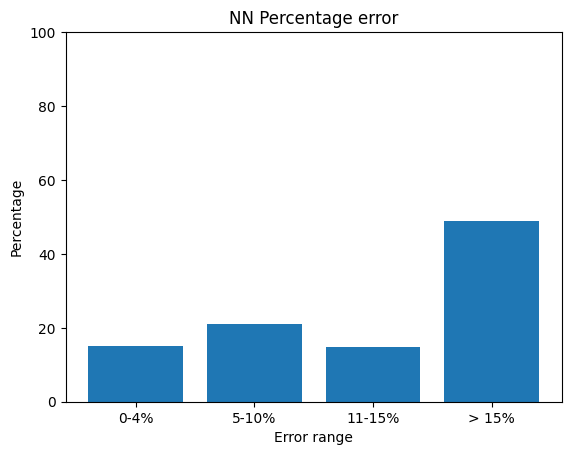

In [42]:
import matplotlib.pyplot as plt

# Data
errors = ['0-4%', '5-10%', '11-15%', '> 15%']
error_counts = [error1_total, error2_total, error3_total, error4_total]
error_percentages = [(count/len(x_test_age))*100 for count in error_counts]

# Create bar chart
plt.bar(errors, error_percentages)

# Add title and axis labels
plt.title('NN Percentage error')
plt.ylabel('Percentage')
plt.xlabel('Error range')
plt.ylim([0, 100])

# Show chart
plt.show()